In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from numpy import linalg as LA
import community

from sklearn.cluster import SpectralClustering, KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_samples, silhouette_score
from scipy.sparse import csgraph


from collections import defaultdict
import string
import random
import copy
import tqdm


import warnings
warnings.simplefilter('ignore')


%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

from pylab import rcParams
import pandas as pd

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

# Data description

Goal of this project is to explore the data-set ”Face-to-face contact patterns in a primary school” with the  help  of  the  graph  theory.   This  data-set  is  comprised  of  face-to-face  contacts  between kids in a primary school in Lyon, aged between 6 and 12 years old.  The data can be represented as weighted, undirected and simple graph which will be exploited to see the underlying facts about the face-to-face recorded contacts between those kids. Knowledge on graphs and two major topics like:  spectral clusterinng and modularity will be engaged to answer different questions about those recorded contacts.

## Explore data

Explore the data obtained from the article. Read the data for the first and second day of the experiment.

In [4]:
RANDOM_STATE = 0

graph_1st_day = nx.read_gexf('../Data/school_interactions/day_1.gexf_')
graph_2st_day = nx.read_gexf('../Data/school_interactions/day_2.gexf_')

## Graph from raw data

Represent the initial data in the form of a graph.

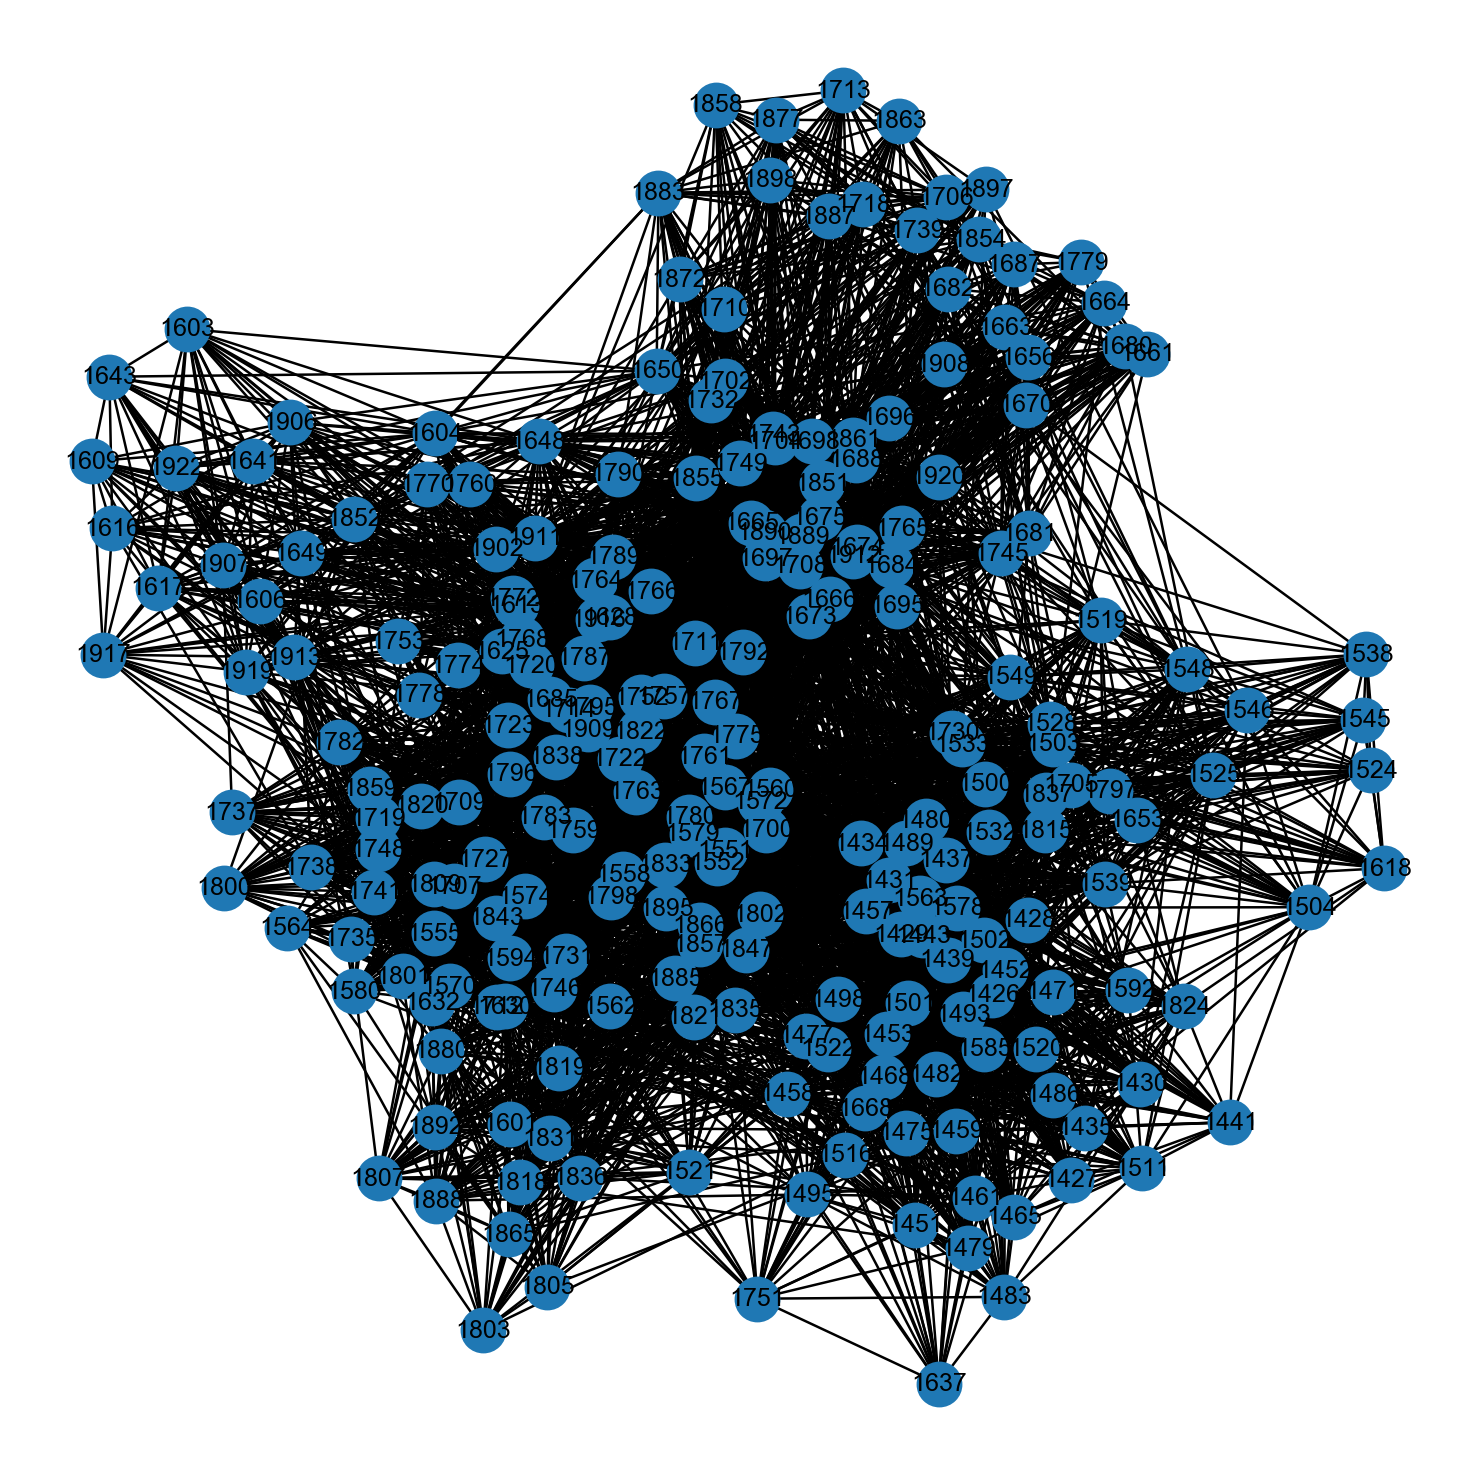

In [5]:
plt.figure(num=None, figsize=(8, 8), dpi=90, facecolor='w', edgecolor='k')
pos = nx.spring_layout(graph_1st_day, scale=50)
nx.draw(graph_1st_day, with_labels=True, layout=pos, font_size=10)
plt.show()

As we can see, we can't draw any conclusions from such representation of the data.

## Basic information of the graph

In [5]:
print(nx.info(graph_1st_day))

Name: 
Type: Graph
Number of nodes: 236
Number of edges: 5899
Average degree:  49.9915


So, we have 236 students and teachers, the total number of contacts among all students and teachers 5899. Moreover, the average number of contacts per person 50.

We can also calculate the density of the graph: $d = \frac{2m}{n(n-1)}$, where $n$ is the number of nodes and $m$ is the number of edges in graph.

In [6]:
nx.density(graph_1st_day)

0.2127298954201226

## Adjacency matrix

In our case adjacency-matrix - matrix of connections between nodes, can be choosen in different ways. As weights we can choose number of contacts between pupils or commulative duration of contacts. In our opinion duration of the contacts is more representable and we will choose this index for furhter testing.

In [7]:
adj_mat_duration = nx.adjacency_matrix(graph_1st_day, nodelist=None, weight='duration')
adj_mat_count = nx.adjacency_matrix(graph_1st_day, weight='count')
adj_mat= nx.adjacency_matrix(graph_1st_day)

## Degree matrix

In [8]:
D = np.diag(np.sum(np.array(adj_mat_duration.todense()), axis=1))
print(D)

[[ 5900     0     0 ...     0     0     0]
 [    0 13380     0 ...     0     0     0]
 [    0     0  5300 ...     0     0     0]
 ...
 [    0     0     0 ...  6880     0     0]
 [    0     0     0 ...     0  9980     0]
 [    0     0     0 ...     0     0 19560]]


## Laplacian matrix

In [9]:
L = D - adj_mat_duration
print(L)

[[ 5900     0     0 ...     0   -80     0]
 [    0 13380   -60 ...     0     0   -20]
 [    0   -60  5300 ...     0   -20     0]
 ...
 [    0     0     0 ...  6880     0     0]
 [  -80     0   -20 ...     0  9980  -140]
 [    0   -20     0 ...     0  -140 19560]]


For example. normalized version also can be found in another way:

In [14]:
L = csgraph.laplacian(adj_mat_duration, normed=True)

In [15]:
L.todense()

matrix([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         -0.01042554,  0.        ],
        [ 0.        ,  1.        , -0.00712501, ...,  0.        ,
          0.        , -0.00123628],
        [ 0.        , -0.00712501,  1.        , ...,  0.        ,
         -0.00274996,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  1.        ,
          0.        ,  0.        ],
        [-0.01042554,  0.        , -0.00274996, ...,  0.        ,
          1.        , -0.01002024],
        [ 0.        , -0.00123628,  0.        , ...,  0.        ,
         -0.01002024,  1.        ]])

## Spectral clustering

### Choose number of clusters: eigengap heuristic

First of all we need to define a suitable number of clusters. 
There are several methods to do that, for example,
* elbow method 
* silhuette score

But there is also a heuristic designed especially for spectral clustering called **eigengap heuristic**, which suitable for all three graph Laplacians. 

**The idea** is to choose number of clusters $k$ such that all eigenvalues $\lambda_1, \ldots, \lambda_k$ are very small, but $\lambda_{k + 1}$ is relatively large. Write a function which will realise this heuristic.

In [18]:
def eigenDecomposition(A, plot = True, topK = 5):
    
    L = csgraph.laplacian(A, normed=True)
    n_components = L.shape[0]
    eigenvalues, eigenvectors = LA.eig(L)
    
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap
    
    if plot:
        trace0 = go.Scatter(x=np.arange(len(eigenvalues)), y=np.sort(eigenvalues)[::-1], name='Eigen values',
                            mode='markers', 
                            line={'dash': 'solid', 'color': 'green'})


        trace1 = go.Scatter(x=index_largest_gap, y=np.sort(eigenvalues)[::-1][index_largest_gap],
                            name='Break points in eigen values',
                            mode='markers', 
                            line={'dash': 'solid', 'color': 'red'})

        data = [trace0, trace1]
        layout = {'title': 'Eigen values in decreasing order',
                      'xaxis_title': 'Index of eigen value',
                      'yaxis_title': 'Eigen value'
                     }

        fig = go.Figure(data=data, layout=layout)
        iplot(fig, show_link=False)    
        
    return nb_clusters, eigenvalues, eigenvectors

In [19]:
k, _,  _ = eigenDecomposition(adj_mat_duration.todense())
print(f'Optimal number of clusters {k}')

Optimal number of clusters [10 34 47 66 90]


### Choose number of clusters: modularity

The idea is to sort out a different number of classes and choose the quantity for which the modularity is maximum.

In [37]:
def Modularity(graph, adj_matrix, n_clusters, plot = True):
    
    labels = []
    for _ in graph_1st_day:
        labels.append(_)
    
    dic_labels = dict(list(enumerate(labels)))
    
    #n_clusters = list(range(5, 20 + 1))
    tests = defaultdict(dict)
    G = nx.from_numpy_matrix(adj_matrix.todense())
    H=nx.relabel_nodes(G,dic_labels)

    for n_cluster in tqdm.tqdm(n_clusters):
        sc = SpectralClustering(n_cluster, affinity='nearest_neighbors', random_state=0)
        sc.fit(adj_matrix)
        y_predict = sc.labels_
        l = {}
        for i, node in enumerate(H.nodes()):
            l.update({node: y_predict[i]})
        tests['Modularity'][n_cluster] = community.modularity(l,H)
    
    if plot:
        df = pd.DataFrame(tests)

        trace0 = go.Scatter(x=n_clusters, y=df['Modularity'], name='Eigen values',
                                    mode='lines+markers', 
                                    line={'dash': 'solid', 'color': 'green'})
        data = [trace0]
        layout = {#'title': 'Eigen values in decreasing order',
                              'xaxis_title': 'Number of clusters',
                              'yaxis_title': 'Modularity',
                              'xaxis_tickvals' : n_clusters
                             }

        fig = go.Figure(data=data, layout=layout)
        iplot(fig, show_link=False)    

    return df

In [38]:
n_clusters = list(range(5, 20 + 1))

results = Modularity(graph_1st_day, adj_mat_duration, n_clusters)

100%|██████████| 16/16 [00:04<00:00,  3.60it/s]


## Choose adjacency matrix

As we work with data about people communication - number of contacts or cumulative duration, it's very important to separate important contacts from unimportant. To conveniently eliminate unnecessary elements of their matrix, we construct the following function:

In [39]:
def prune_short_interactions(matrix: np.ndarray, min_interaction: int) -> np.ndarray:
    out = matrix.copy()
    out[out < min_interaction] = 0
    return out

Calculate silhouette score for different adjacency matrices based on duration

In [41]:
min_interactions = list(range(0, 200 + 1))
tests = defaultdict(dict)

for min_interaction in tqdm.tqdm(min_interactions):
    adj_mat_pruned = prune_short_interactions(adj_mat_duration, min_interaction)
    sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=0)
    sc.fit(adj_mat_pruned)


    tests[10][min_interaction] = silhouette_score(adj_mat_pruned, sc.labels_)

100%|██████████| 201/201 [01:03<00:00,  3.18it/s]


In [42]:
df = pd.DataFrame(tests)

trace0 = go.Scatter(x=np.arange(0, 200 + 1), y=df[10], name='Eigen values',
                            mode='markers', 
                            line={'dash': 'solid', 'color': 'green'})
data = [trace0]
layout = {#'title': 'Eigen values in decreasing order',
                      'xaxis_title': 'Min duration of communcation',
                      'yaxis_title': 'Silhouette score'
                     }

fig = go.Figure(data=data, layout=layout)
iplot(fig, show_link=False)  

As you can see reducing the minimum interaction time does not increase the score. The best score was obtained with minimum talk time equal to $40$.

## Silhuette scores example

In [43]:
x, y = make_blobs(n_samples=1500, random_state=100)

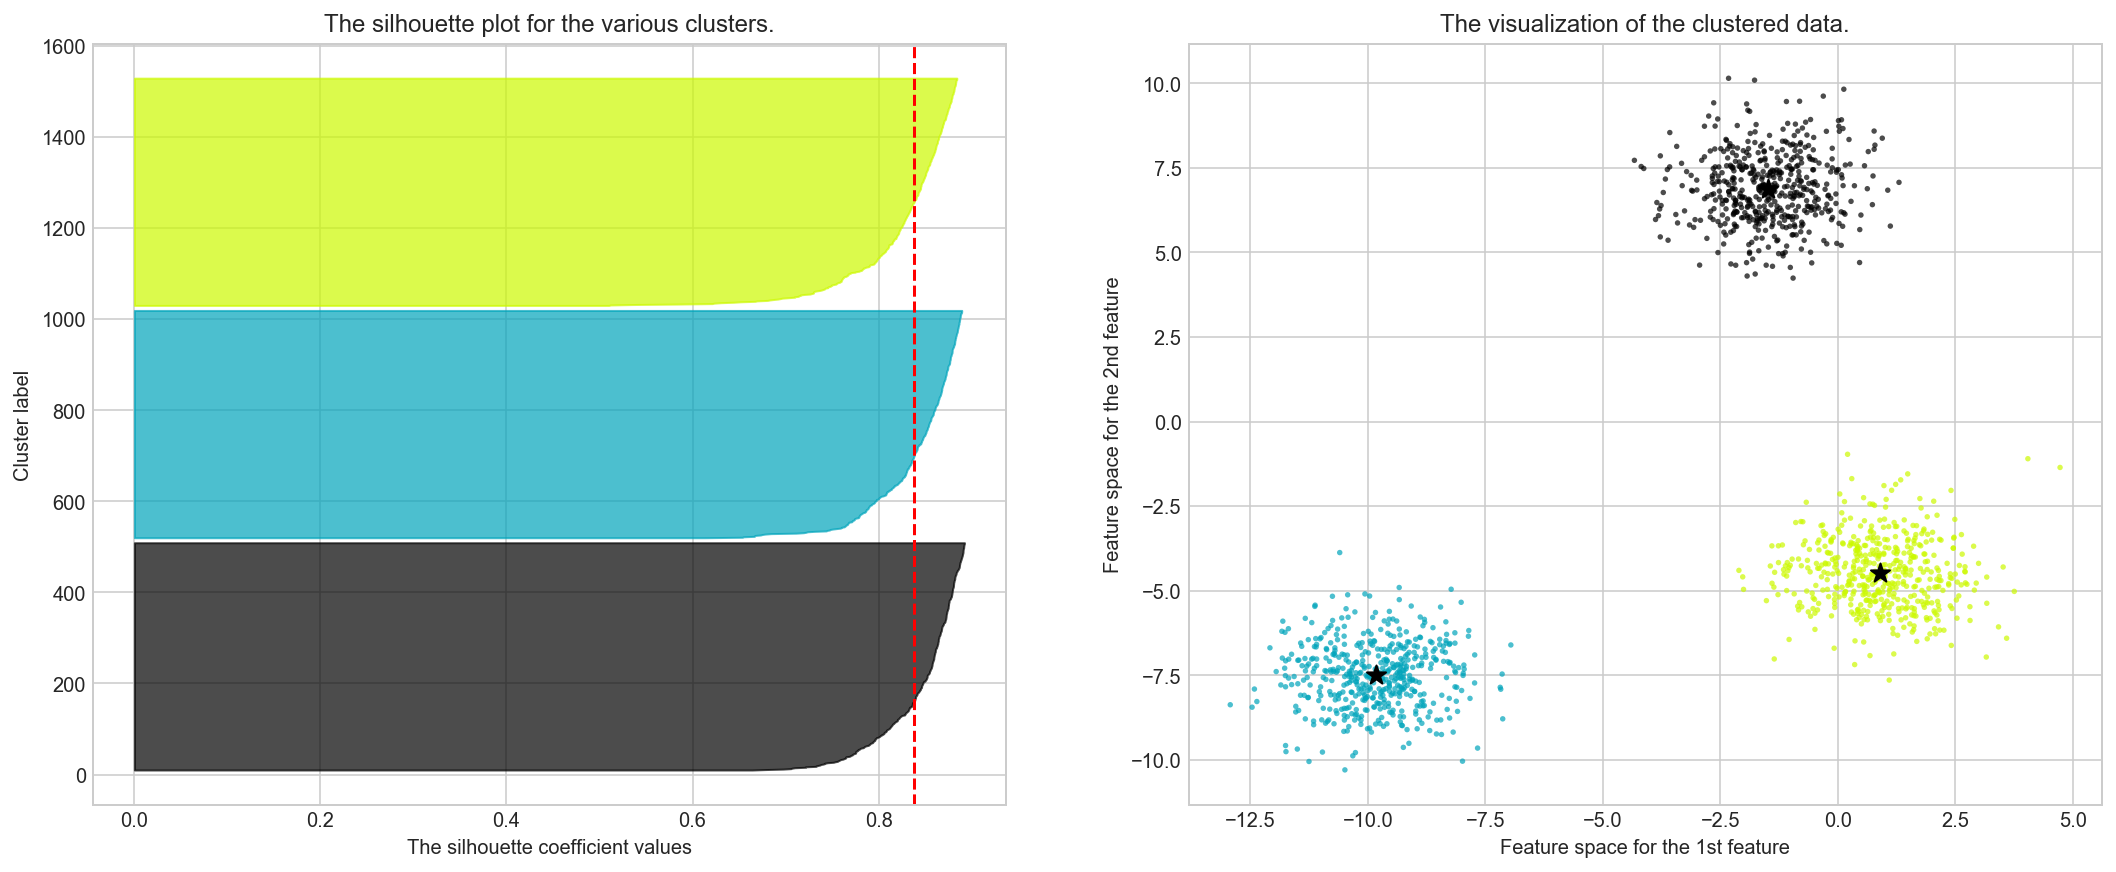

In [50]:
km = KMeans(n_clusters=3, n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_pred = km.fit_predict(x)

silhouette_vals = silhouette_samples(x, y_pred)
clusters_labels = np.unique(y_pred)
nb_clusters = clusters_labels.shape[0]
y_lower = 10

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

for i in range(nb_clusters):
    cluster_silhouette_vals = silhouette_vals[y_pred == i]
    cluster_silhouette_vals.sort()
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size
    color = cm.nipy_spectral(i / nb_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor = color, edgecolor=color, alpha = 0.7)
    
    y_lower = y_upper + 10

silhouette_avg = silhouette_score(x, y_pred)
ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")


colors = cm.nipy_spectral(y_pred/ nb_clusters)
ax2.scatter(x[:, 0], x[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor=colors)
ax2.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=100, marker='*', c='black')
ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

#plt.suptitle((f'Silhouette analysis for KMeans clustering on sample data with n_clusters = {nb_clusters}'), fontsize=14, fontweight='bold')

fig.show()

## Clustering results

In [51]:
adj_mat_pruned = prune_short_interactions(adj_mat_duration, 40)
sc = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=0)
sc.fit(adj_mat_pruned)

SpectralClustering(affinity='nearest_neighbors', assign_labels='kmeans',
                   coef0=1, degree=3, eigen_solver=None, eigen_tol=0.0,
                   gamma=1.0, kernel_params=None, n_clusters=10,
                   n_components=None, n_init=10, n_jobs=None, n_neighbors=10,
                   random_state=0)

In [52]:
predicted_labels = sc.labels_
pupils_id = list(graph_1st_day)

In [53]:
school = dict()

# create dictionary label for our new graph
with open('metadata_primaryschool.txt') as f:
    for line in f:
        key, classname, gender = line.split()
        school[key] = classname

In [54]:
true_classes = []
for pupil_id in pupils_id:
    if pupil_id in school:
        true_classes.append(school[pupil_id])

In [55]:
all_lables= [predicted_labels, pupils_id, true_classes]
df_pd_1 = pd.DataFrame(np.array(all_lables).T, columns = ['Label', 'Student ID', 'Real class'])
df2 = pd.pivot_table(df_pd_1, values = 'Student ID', index = ['Real class'], columns = ['Label'], aggfunc=len)

In [63]:
dict_clust = {'7':'1A', '3':'1B', '8':'2A', '1':'2B', '6':'3A', '4':'3B', '2':'4A', '9':'4b', '5':'5A', '0':'5b'}

In [64]:
predicted_classes = []
for predicted_label in predicted_labels:
    if str(predicted_label) in dict_clust:
        predicted_classes.append(dict_clust[str(predicted_label)])

In [65]:
df_pd_1['Predicted class'] = predicted_classes

In [66]:
real_cl = df_pd_1[df_pd_1['Real class'] != 'Teachers']['Real class'].tolist()
pred_cl = df_pd_1[df_pd_1['Real class'] != 'Teachers']['Predicted class'].tolist()

In [67]:
score = accuracy_score(real_cl, pred_cl)

In [68]:
score

0.7654867256637168

In [69]:
df3 = pd.pivot_table(df_pd_1[df_pd_1['Real class'] != 'Teachers'], values = 'Student ID', index = ['Predicted class'], columns = ['Real class'], aggfunc=len)

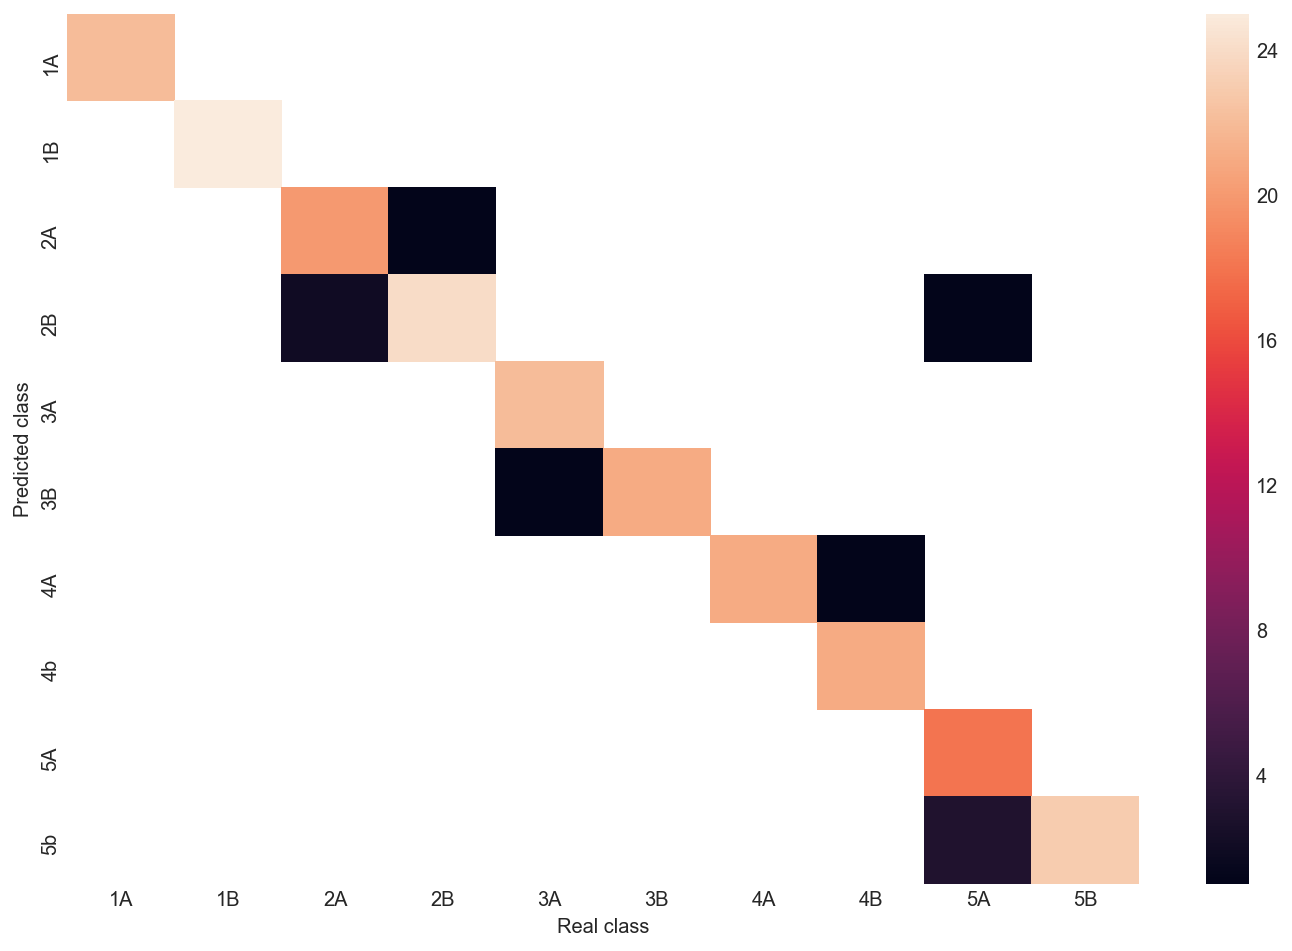

In [70]:
sns.heatmap(df3);